# RNN and BPTT

In [1]:
# to avoid dead kernel error when using Pytorch.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Import

In [2]:
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import copy
from tqdm import tqdm
from termcolor import colored  # for printing coloured text
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset: "Origin of Species"

In [3]:
import re
class Origin(torch.utils.data.Dataset):
    '''
     ds = Origin(seq_length=10, start=0, stop=-1)
     
     Creates a PyTorch Dataset object: holding a simplified version
     of the text from Charles Darwin's "On the Origin of Species".
     
     The class contains utility functions to convert between the
     string-based form of a sequence, and its vector encoding, in which
     each character is represented by a one-hot 28-vector corresponding
     to the 28 characters in the string
       ' .abcdefghijklmnopqrstuvwxyz'  (the first character is a space)
     
     The target sequences are the same as the inputs, but advanced by
     one character.
     
     Inputs:
      seq_length  the number of characters in each sequence
      start       the index of the character to start taking sequences from
      stop        the index of the character to stop taking sequences from
      
     Usage:
      ds = Origin(seq_length=5, start=7, stop=100)
      x,t = ds.__getitem__(0)
      print(ds.read_seq(x))   # Produces 'origi'
      print(ds.read_seq(t))   # Produces 'rigin'
    '''
    def __init__(self, seq_length=10, start=0, stop=-1):
        self.seq_length = seq_length

        orig_text = open('origin_of_species.txt').read().lower()
        chars = sorted(list(set(orig_text)))
        chars.insert(0, "\0") #Add newline character
        vocab_size = len(chars)

        char_indices = dict((c, i) for i, c in enumerate(chars))
        indices_char = dict((i, c) for i, c in enumerate(chars))
        idx = [char_indices[c] for c in orig_text]

        # keep only letters, spaces, and periods.
        filt_idx = []
        for i in idx:
            if i<=24 and i!=10:
                filt_idx.append(2)
            elif i>24 or i==10:
                filt_idx.append(i)
        blah = ''.join([indices_char[f] for f in filt_idx])
        self.text = re.sub(' +', ' ', blah)  # collapse multiple spaces using regular expressions
        self.text = self.text[start:stop]
        #chars = sorted(list(set(self.text)))
        chars = sorted(list(set(' .abcdefghijklmnopqrstuvwxyz')))
        self.vocab_size = len(chars)
        print('Character set: '+''.join(chars)+' (first char is a space)')

        self.char_indices = dict((c, i) for i, c in enumerate(chars))
        self.indices_char = dict((i, c) for i, c in enumerate(chars))
        self.idx = [self.char_indices[c] for c in self.text]

        print('There are '+str(self.vocab_size)+' characters in our character set')

    def __len__(self):
        return len(self.text) - 1 - self.seq_length
    
    def __getitem__(self, k):
        x = self.idx[k:k+self.seq_length]
        t = self.idx[k+1:k+1+self.seq_length]
        return self.seq_i2v(x), torch.tensor(t, dtype=torch.long)
      
    def seq_i2v(self, seq):
        x = torch.zeros((len(seq), self.vocab_size))
        for k,i in enumerate(seq):
            x[k,i] = 1.
        return x
    
    def read_seq(self, x):
        idx = [torch.argmax(v).item() for v in x]        
        return ''.join(self.indices_char[i] for i in idx)
    
    def encode_seq(self, c):
        idx = [self.char_indices[cc] for cc in c]
        return self.seq_i2v(idx)

In [4]:
# Create the dataset
oos = Origin(start=11000, stop=21000, seq_length=10)

Character set:  .abcdefghijklmnopqrstuvwxyz (first char is a space)
There are 28 characters in our character set


In [5]:
# How many sequences?
len(oos)

9989

In [6]:
# the original (simplified) text.
oos.text[820:900]

'en yield new varieties our oldest domesticated animals are still capable of rapi'

In [7]:
x, t = oos.__getitem__(0)

In [8]:
print('Here is how you can view one of the samples:')
print(f'Sample input: "{oos.read_seq(x)}"')

Here is how you can view one of the samples:
Sample input: "treatment "


In [9]:
# Create a PyTorch DataLoader
dl = torch.utils.data.DataLoader(oos, batch_size=128, shuffle=True)

# `GRU` Class

In [10]:
class GRU(nn.Module):
    '''
     net = GRU(dims)
     Input:
       dims is [I, H], where the input/output layers have I neurons, and the
            hidden layer has H neurons.
    '''
    def __init__(self, dims):
        super().__init__()
        self.losses = []
        
        #===== YOUR CODE HERE =====
        self.input_dim, self.hidden_dim = dims
        self.Uz = nn.Linear(self.input_dim, self.hidden_dim)
        self.Wz = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.bz = nn.Parameter(torch.zeros(1, self.hidden_dim))
        self.Ur = nn.Linear(self.input_dim, self.hidden_dim)
        self.Wr = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.br = nn.Parameter(torch.zeros(1, self.hidden_dim))
        self.Uh = nn.Linear(self.input_dim, self.hidden_dim)
        self.Wh = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.bh = nn.Parameter(torch.zeros(1, self.hidden_dim))
        
        self.V = nn.Linear(self.hidden_dim, self.input_dim)
        self.by = nn.Parameter(torch.zeros(1, self.input_dim))
        
    def step(self, x, h):
        '''
         hnext = net.step(x, h)
         
         Takes a time step, with input x and current hidden state h.
         Returns the new h.
         
         Inputs:
          x      a DxI tensor holding a batch of inputs, where
                    D is the batch size, and
                    I is the dimension of the inputs
          h      a DxH tensor holding a batch of hidden states, where
                    H is the number of hidden nodes
                
         Output:
          hnext  a DxH tensor holding the hidden states for the next
                    timestep
        '''
        
        zt = nn.Sigmoid()(self.Uz(x) + self.Wz(h) + self.bz)
        rt = nn.Sigmoid()(self.Ur(x) + self.Wr(h) + self.br)
        ht_tilda = nn.Tanh()(self.Uh(x) + self.Wh(rt * h) + self.bh)
        hnext = (1 - zt) * h + zt * ht_tilda
        return hnext
    
    
    def output(self, h):
        '''
         y = net.output(h)
         
         Given the hidden state, returns the *log* of the output.
         ie. for categorical cross-entropy, it should return LogSoftmax.
         
         Input:
          h  a DxH tensor holding a batch of hidden states, where
                D is the batch size, and
                H is the dimension of the hidden state (number of hidden nodes)
                
         Output:
          y  a DxI tensor holding a batch of outputs, where
                I is the dimension of the output
        '''
        
        y = nn.functional.log_softmax(self.V(h) + self.by, dim=1)
        return y
    
    
    def forward(self, x):
        '''
         y = net.forward(x)
         
         Takes a batch of squences, and returns the batch of output
         sequences.
         
         Inputs:
          x   a DxTxI tensor, where
                 D is the batch size (number of sequences in the batch)
                 T is the sequence length, and
                 I is the dimension of the input to the network
                 
         Output:
          y   a DxTxI tensor, as above
        '''
        x = x.to(device)  # GPU
        # to reorder the batch from (D, T, I) to (T, D, I) so that
        # we can run the batch through the network, one timestep at a time.
        seq_of_batches = torch.einsum('ijk->jik', x)

        output_seq = []
        T, samples, input_dim = seq_of_batches.shape
        h = torch.zeros((samples, self.hidden_dim)).to(device)
        for xt in seq_of_batches:
            h = self.step(xt, h)
            output_seq.append(self.output(h))
        y = torch.stack(output_seq, dim=0).to(device)  # (T, batch_size, output_dim)
        return torch.einsum('jik->ijk', y)  # (batch_size, T, output_dim)

    
    def bptt(self, dl, epochs=10, loss_fcn=nn.NLLLoss(), lr=0.001):
        '''
         net.bptt(dl, epochs=10, loss_fcn=nn.NLLLoss(), lr=0.001)
         
         Trains the recurrent network using Backprop Through Time.
         
         Inputs:
          dl        PyTorch DataLoader object
                    Each batch shoud be shaped DxTxI where
                      D is the number of sequences (samples) in the batch,
                      T is the length of each sequence, and
                      I is dim of each input to the network
          epochs    number of epochs to train for
          loss_fcn  PyTorch loss function
          lr        learning rate
        '''
        optim = torch.optim.Adam(self.parameters(), lr=lr)  # optimizer
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x,t in (dl):
                y = self(x)   # process the batch of sequences
                
                # Go through output sequences, and compute loss
                loss = torch.tensor(0., device=device, requires_grad=True)
                for ys,ts in zip(y,t.to(device)):
                    loss = loss + loss_fcn(ys, ts)
                    
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.detach().cpu().item()
                
            self.losses.append(total_loss/len(dl))
        plt.plot(self.losses)
        
        
    def predict(self, x, n=10):
        '''
         y = net.predict(x, n=10)
         
         Run the network on sequence x, and then continue to predict
         the next n outputs.
         
         Inputs:
          x  a TxI tensor for a single input sequence
          n  how many output timesteps to predict
          
         Output:
          y  an (n)xI tensor, holding the sequence of n outputs
                predicted after the input sequence
        '''
        assert len(x.shape)==2
        with torch.no_grad():
            h = torch.zeros((1, self.hidden_dim)).to(device)
            for xx in x:  # step through the given sequence
                h = self.step(xx, h)
            y = self.output(h)
            pred = [y]   # for storing the output sequence
            
            # take n more steps, and add the network's output
            for t in range(n-1):
                # Make a one-hot input out of the last output
                c = torch.argmax(y)
                x = torch.zeros_like(y)
                x[0,c] = 1.
                # Take a timestep
                h = self.step(x, h)
                y = self.output(h) # output from prev step becomes input to next step
                pred.append(y)
                
        return torch.stack(pred, dim=0)

# Create and train the GRU

In [11]:
net = GRU([oos.vocab_size, 400])

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [13:15<00:00, 19.88s/it]


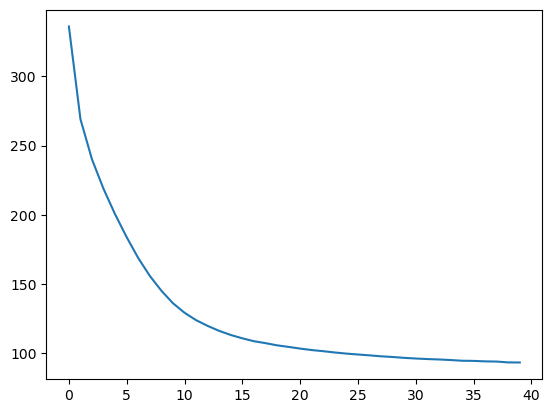

In [12]:
net.bptt(dl, epochs=40, loss_fcn=nn.NLLLoss(reduction='mean'), lr=0.001)

In [13]:
# save the trained network.
# torch.save(net.cpu(), 'mygru.pt')

In [14]:
#load the trained network
# net = torch.load('mygru.pt').to(device)

# Evaluate the network

In [15]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(oos))
rs = oos.read_seq  # shorthand for the function
s = oos.__getitem__(k)[0].to(device)  # s holds the seq

# Feed the seq in to the net, and ask for the next 10 characters
pred_seq = net.predict(s, n=10).cpu()

print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
snext = oos.__getitem__(k+oos.seq_length)[0]  # the following sequence
print(f'Actual:       {rs(s)+rs(snext)}')

Input:        ere variat
Prediction:   ere variation seems 
Actual:       ere variations. but 


In [16]:
# Let's predict a longer sequence
word = 'ch species'  # choosing our own see seq
v = oos.encode_seq(word)  # encode it
y = net.predict(v, n=50)  # predict next 50 characters
print(f'{oos.read_seq(v)}'+colored(oos.read_seq(y), 'red'))

ch species have pollen utterly worthless in the case of plan


## Matching string length

In [17]:
# Run experiment on a bunch of random seed sequences.
# - choose random seed seq
# - predict next 100 characters
# - find out how many characters match the text

result_array = [0] * 101
for i in range(200):
    k = np.random.randint(0, high=len(oos))
    seq = oos.__getitem__(k)[0].to(device)
    pred_seq = net.predict(seq, n=100).cpu()
    text = oos.read_seq(seq) + oos.read_seq(pred_seq)
    count = 0
    match = oos.text.find(text[:count])
    while match != -1:
        if text == text[:count]:
            count += 1
            break
        count += 1
        match = oos.text.find(text[:count])
    count -= 11
    for i in range(count + 1):
        result_array[i] += 1

In [18]:
print("The number of times the model’s predictions match the subsequent text:")
for i in range(len(result_array)):
    print("for at least " + str(i) + " characters is", result_array[i])

The number of times the model’s predictions match the subsequent text:
for at least 0 characters is 200
for at least 1 characters is 200
for at least 2 characters is 191
for at least 3 characters is 188
for at least 4 characters is 181
for at least 5 characters is 170
for at least 6 characters is 160
for at least 7 characters is 150
for at least 8 characters is 136
for at least 9 characters is 129
for at least 10 characters is 122
for at least 11 characters is 111
for at least 12 characters is 104
for at least 13 characters is 98
for at least 14 characters is 86
for at least 15 characters is 78
for at least 16 characters is 77
for at least 17 characters is 69
for at least 18 characters is 63
for at least 19 characters is 58
for at least 20 characters is 56
for at least 21 characters is 50
for at least 22 characters is 45
for at least 23 characters is 44
for at least 24 characters is 42
for at least 25 characters is 40
for at least 26 characters is 38
for at least 27 characters is 37
fo

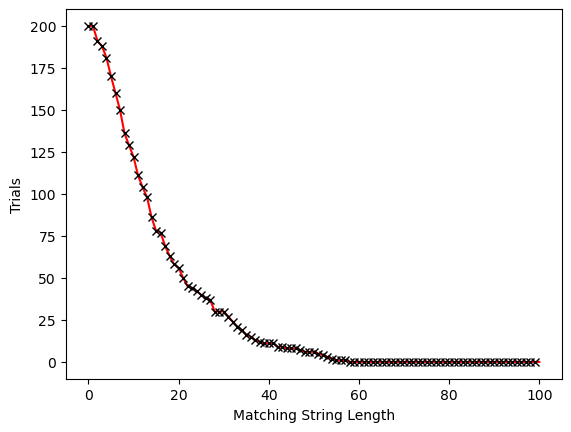

In [19]:
# Plot matching-length vs trials
plt.plot(result_array, c = "red")
plt.xlabel('Matching String Length')
plt.ylabel('Trials')
for i in range(100):
    plt.plot(i, result_array[i], marker='x', c = "black")
plt.show()